**Purpose:**
This Jupyter notebook serves as a comprehensive guide and example for leveraging the MiDaS 3.1 depth estimation model and its diverse variants developed by Intel. The primary objective is to demonstrate how to effectively utilize the capabilities of this repository, providing users with practical insights into implementing the MiDaS depth estimation model in the eufs pipeline.

**Notable Dependency**
- timm - 0.6.12
- torch - 2.0.1
- torchvision - 0.15.2

**Ranftl, R., Lasinger, K., Hafner, D., Schindler, K., & Koltun, V. (2020).**
*Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer.*
**IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI).**

## Global Variables

---

In [1]:
# Model name from the official list (complete list avilable at midas/model_loader.py). 
# Weights must be downloaded in the weights folder.
modelname = "dpt_swin2_tiny_256" 


## Run with Pytorch

---

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time

from utils import read_image
from midas.model_loader import load_model, default_models

/home/julien/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# Loads model using the API
model_path = default_models[modelname]

device = "cpu"

pt_model, transform, net_w, net_h = load_model(device, model_path, modelname,
	optimize=False, square=True)

/home/julien/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /root/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded, number of parameters = 42M


In [4]:
# 1. Input loading
start_time = time.time()
img = read_image("input/frame_00001.bmp")
end_time = time.time()

target_size = img.shape[1::-1] # Necessary to interpolate to the correct size


input_time = end_time - start_time

# 2. Preprocessing
start_time = time.time()
img_input = transform({"image": img})["image"]
end_time = time.time()

preprocessing_time = end_time - start_time

# 3. Inference
start_time = time.time()
with torch.no_grad():
	sample = torch.from_numpy(img_input).to(device).unsqueeze(0)
	pt_output = pt_model.forward(sample)
end_time = time.time()

inference_time = end_time - start_time

# 4. Interpolation
start_time = time.time()
prediction = (
            torch.nn.functional.interpolate(
                pt_output.unsqueeze(1),
                size=target_size[::-1],
                mode="bicubic",
                align_corners=False,
            )
            .squeeze()
            .cpu()
            .numpy())
end_time = time.time()

interpolation_time = end_time - start_time


**Plotting the process**

---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


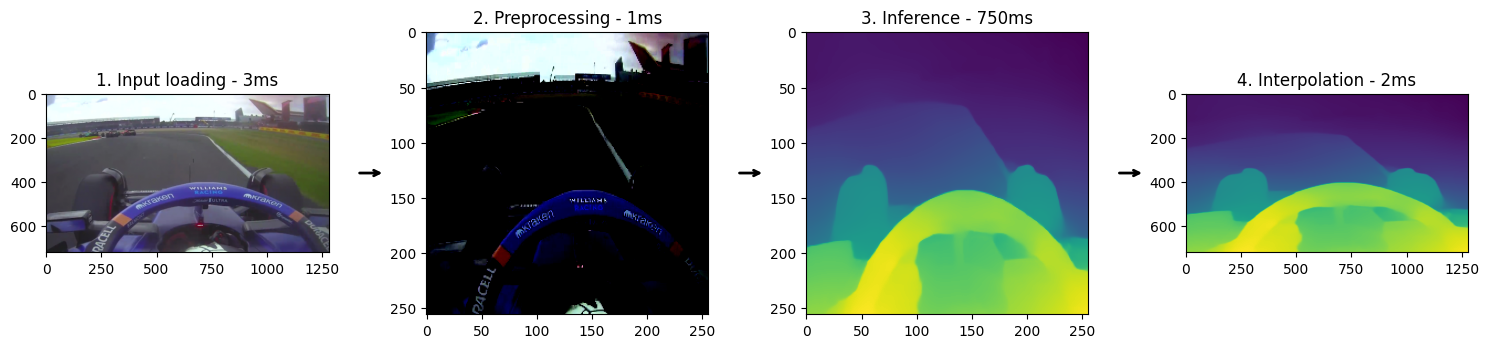

In [5]:
def normalize(arr: np.array):
	minval = arr.min()
	maxval = arr.max()
	return (arr - minval) / (maxval - minval)

# Create a larger figure
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

images = [img, img_input.transpose(1, 2, 0), normalize(pt_output.squeeze().cpu().numpy()), normalize(prediction)]
titles = ["1. Input loading - " + str(int(input_time*1000)) + "ms", "2. Preprocessing - " + str(int(preprocessing_time*1000)) + "ms", "3. Inference - " + str(int(inference_time*1000)) + "ms", "4. Interpolation - " + str(int(interpolation_time*1000)) + "ms"]

for i, (im, title) in enumerate(zip(images, titles)):
    axs[i].imshow(im, vmin=0, vmax=1)
    axs[i].set_title(title)

# Add arrows
for i in range(3):
    axs[i].annotate("", xy=(1.2, 0.5), xycoords='axes fraction', xytext=(1.1, 0.5), 
                    arrowprops=dict(arrowstyle="->", lw=2))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()



## Run with ONNx

---


To export a model to a .onnx file, please use /onnx/make_onnx_model.py

In [6]:
import onnxruntime as rt
import numpy as np
import math
import matplotlib.pyplot as plt

from utils import read_image

In [7]:
onnx_model_path = f"./onnx/{modelname}.onnx"
onnx_model = rt.InferenceSession(onnx_model_path)

In [8]:
input_name = onnx_model.get_inputs()[0].name
output_name = onnx_model.get_outputs()[0].name
onnx_output = onnx_model.run([output_name], {input_name: img_input.reshape(1, 3, net_h, net_w).astype(np.float32)})[0]

**result comparison with original pytorch model**

---

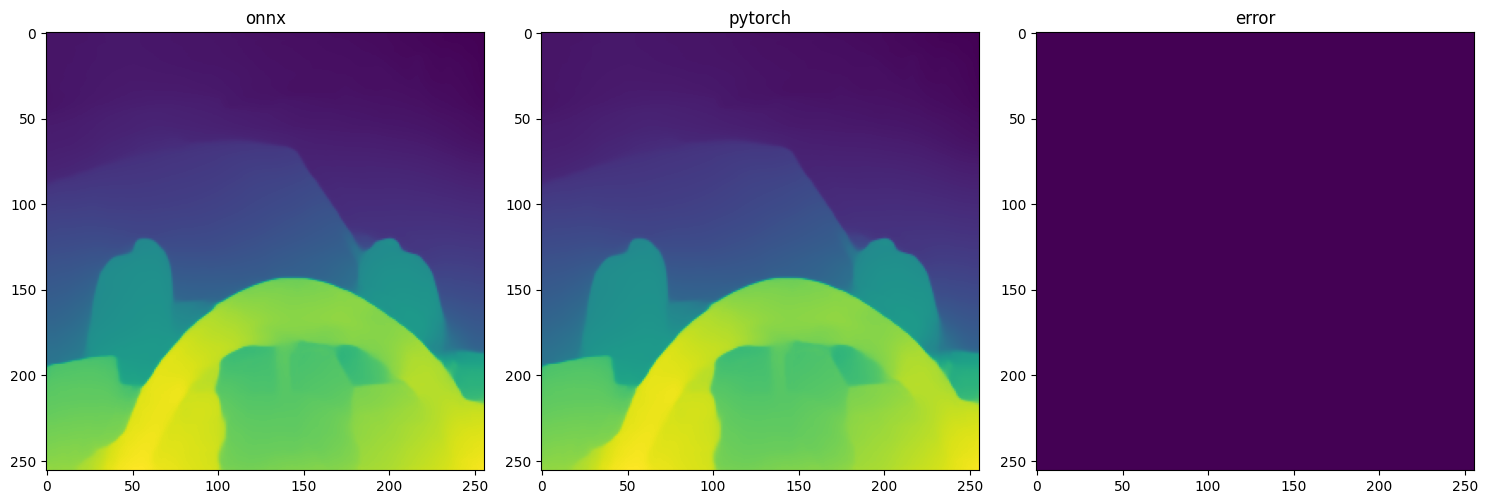

--->ERROR<---

rmse: 0.00000025
min: -0.00000417
max: 0.00000140
std: 0.00000025


In [9]:
onnx_output_norm = normalize(onnx_output)[0]
pt_output_norm = normalize(pt_output.squeeze().cpu().numpy())

norm_err = onnx_output_norm - pt_output_norm

# Create a larger figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, im, title in zip([1, 2, 3], [onnx_output_norm, pt_output_norm, norm_err], ["onnx", "pytorch", "error"]):
	plt.subplot(1, 3, i)
	plt.imshow(im, vmin=0, vmax=1)
	plt.title(title)

plt.tight_layout()
plt.show()


norm_mse = (norm_err ** 2).mean()
norm_rmse = math.sqrt(norm_mse)

print("--->ERROR<---\n")
for stat, val in zip(["rmse", "min", "max", "std"], [norm_rmse, norm_err.min(), norm_err.max(), norm_err.std()]):
	print(f"{stat}: {val:.8f}")

## About Midas Transforms:

---

This section addresses the resizing and normalizing preprocessing steps integral to the Midas depth estimation model. Each standard model variant is associated with a specific set of transformations tailored to its requirements.

#### Implementation Details:

1. **midas/model_loader.py:** 
   - This file details which transformations are essential for each model. Refer to it to understand the specific preprocessing requirements for your network implementation.

2. **midas/transforms.py:** 
   - This file contains the actual implementation of the transformations.

Feel free to consult these files for a comprehensive understanding of the preprocessing steps and adapt them as needed for specialized network implementations.

### Example for dpt_swin2_tiny_256

```python
elif model_type == "dpt_swin2_tiny_256":
        model = DPTDepthModel(
            path=model_path,
            backbone="swin2t16_256",
            non_negative=True,
        )
        net_w, net_h = 256, 256
        keep_aspect_ratio = False
        resize_mode = "minimal"
        normalization = NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

transform = Compose(
        [
            Resize(
                net_w,
                net_h,
                resize_target=None,
                keep_aspect_ratio=keep_aspect_ratio,
                ensure_multiple_of=32,
                resize_method=resize_mode,
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            normalization,
            PrepareForNet(),
        ]
    )
```



```
+-------------------+    +-------------------+    +-----------+    +---------------------+
|   Original Image  | -> | Resize (256, 256) | -> | Normalize | -> | Transpose (2, 0, 1) |
+-------------------+    +-------------------+    +-----------+    +---------------------+
